In [1]:
import os
import re
import numpy as np
import pandas as pd
import gzip
import time
import matplotlib.pyplot as plt
%matplotlib inline
print('Packages loaded')

Packages loaded


In [2]:
def regex_match(start_with, end_with, folder):
    m = re.search(start_with+end_with, folder)
    if m!=None:
        return True
    else:
        return False

_maf_re = re.compile(r'\bMAF=([^;]+)')

def extract_maf_regex(info_str):
    """
    Use a regular expression to grab the MAF= value.
    """
    m = _maf_re.search(info_str)
    if not m:
        return None
    try:
        return float(m.group(1))
    except ValueError:
        return None

def classify_maf(maf):
    if maf < 0.001:
        return 'rare'
    elif maf > 0.05:
        return 'common'
    else:
        return 'none'

## SNV distribution in chromosomes

In [38]:
def read_vcf(vcf_file_path):
    """
    Read a gzipped VCF into a pandas DataFrame, dropping '##' meta‑lines.
    """
    with gzip.open(vcf_file_path, 'rt') as f:
        # keep only the header line (#CHROM ...) + data lines
        lines = [l for l in f if not l.startswith('##')]
    # join and read with pandas
    vcf_str = "".join(lines)
    df = pd.read_csv(io.StringIO(vcf_str), sep='\t')
    return df

def read_vcf(vcf_file_path):
    """
    Reads data from vcf file and parse lines into pandas dataframe
        Parameters:
            vcf_file_path: str
        
        Returns:
            pandas dataframe with columns ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]
    """
    VCF_REQUIRED_COLS = ["#CHROM", "POS", "ID", "REF", "ALT"]
    with gzip.open(vcf_file_path, 'rb') as file_handle:
        lines = file_handle.readlines()
        
        # handling first few lines
        index = 0
        for index, line in enumerate(lines):
            line = line.decode('utf8')
            if '#' not in line:
                break
            if "#CHROM" in line:
                cols = line.strip().split('\t')
                if cols[:5] != VCF_REQUIRED_COLS:
                    raise ValueError(
                        "First 5 columns in file {0} were {1}. "
                        "Expected columns: {2}".format(
                            input_path, cols[:5], VCF_REQUIRED_COLS))
                index += 1
                break  
         
    # handling remaining lines of vcf file
    variants = []
    for line in lines[index:]:
        line = line.decode('utf8')
        cols = line.strip().split('\t')
        variants.append(cols)

    df = pd.DataFrame(variants)
    print(df.shape)
    df.columns = ["CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO"]
    return df

def remove_extra_chroms(input_df):
    """
    Removes chromosomes other than 1-22
        Parameters:
            df: pandas dataframe with chrom as one of the columns
        Returns:
            Pandas dataframe
    """
    chroms = [str(chrom) for chrom in range(1, 23)]
    df = pd.DataFrame()
    input_df['chrom'] = input_df['chrom'].astype(str)
    for chrom in chroms:
        chr_df = input_df[input_df['chrom']==str(chrom)]
#         print(chrom, chr_df.shape)
        df = pd.concat([df, chr_df])
    df.reset_index(drop=True, inplace=True)
    for col in df.columns:
        try:
            if col.lower() == 'chrom':
                df['chrom'] = df['chrom'].astype(np.uint8)
            elif col.lower() in ['pos', 'start', 'end']:
                df[col] = df[col].astype(np.uint32)
        except:
            pass
    print('Extra chromosomes have been deleted and sorted by chrom and pos/start')
    for col in df.columns:
        try:
            if col.lower() in ['pos', 'start']:
                df.sort_values(by=['chrom', col], inplace=True, ignore_index=True)
        except:
            pass
    print('Data is sorted by chrom followed by pos/start')
    return df

In [5]:
release = 112
inPath = f'/scratch/ml-csm/datasets/genomics/ref-genome/human/GRCh38/ensembl/variants/release-{release}/chrom/'
files = os.listdir(inPath)
files.sort()
print(len(files))

chroms = [i for i in range(1, 23)]

num_var = {}
for chrom in chroms:
    file = f'homo_sapiens-chr{chrom}.vcf.gz'
    df = read_vcf(inPath + file)
    print(file, df.shape)
    num_var[chrom] = df.shape[0]


df_num_var = pd.DataFrame.from_dict(num_var, orient='index')
df_num_var.columns = ['num_var']
print(f"Total {df_num_var['num_var'].sum()}")
df_num_var.insert(loc=0, column='chrom', value=df_num_var.index)
df_num_var['chrom'] = df_num_var['chrom'].astype(str)
df_num_var.loc[len(df_num_var)] = ['Total', df_num_var['num_var'].sum()]
df_num_var.to_csv(f'GVE_peak/genomics/df_num_var_release{release}.csv', index=False)
df_num_var

23
homo_sapiens-chr1.vcf.gz (86805302, 8)
homo_sapiens-chr2.vcf.gz (92129233, 8)
homo_sapiens-chr3.vcf.gz (75290328, 8)
homo_sapiens-chr4.vcf.gz (72774867, 8)
homo_sapiens-chr5.vcf.gz (68010234, 8)
homo_sapiens-chr6.vcf.gz (63580227, 8)
homo_sapiens-chr7.vcf.gz (60883859, 8)
homo_sapiens-chr8.vcf.gz (57196924, 8)
homo_sapiens-chr9.vcf.gz (47776247, 8)
homo_sapiens-chr10.vcf.gz (50907066, 8)
homo_sapiens-chr11.vcf.gz (52111469, 8)
homo_sapiens-chr12.vcf.gz (50405318, 8)
homo_sapiens-chr13.vcf.gz (37820559, 8)
homo_sapiens-chr14.vcf.gz (33710064, 8)
homo_sapiens-chr15.vcf.gz (31524384, 8)
homo_sapiens-chr16.vcf.gz (33877605, 8)
homo_sapiens-chr17.vcf.gz (30633422, 8)
homo_sapiens-chr18.vcf.gz (29708859, 8)
homo_sapiens-chr19.vcf.gz (22906446, 8)
homo_sapiens-chr20.vcf.gz (24192809, 8)
homo_sapiens-chr21.vcf.gz (14431660, 8)
homo_sapiens-chr22.vcf.gz (14912992, 8)
Total 1051589874


,chrom,num_var
1,1,86805302
2,2,92129233
3,3,75290328
4,4,72774867
5,5,68010234
6,6,63580227
7,7,60883859
8,8,57196924
9,9,47776247
10,10,50907066


In [5]:
df_num_var = pd.read_csv('df_num_var_release108.csv')
df_num_var['var%'] = df_num_var['num_var']*100/df_num_var['num_var'].sum()
df_num_var, df_num_var['num_var'].sum(), df_num_var['var%'].sum()

(    chrom   num_var      var%
 0       1  54950388  8.178794
 1       2  58802274  8.752107
 2       3  48098212  7.158919
 3       4  46221323  6.879563
 4       5  43338895  6.450544
 5       6  40569160  6.038298
 6       7  38921175  5.793012
 7       8  36818232  5.480011
 8       9  30548188  4.546780
 9      10  32448977  4.829693
 10     11  33255335  4.949711
 11     12  32146515  4.784675
 12     13  23665483  3.522361
 13     14  21621402  3.218121
 14     15  20235594  3.011858
 15     16  22226709  3.308215
 16     17  19772918  2.942993
 17     18  18736706  2.788764
 18     19  15201974  2.262656
 19     20  15418796  2.294928
 20     21   9243118  1.375742
 21     22   9622809  1.432255,
 671864183,
 100.0)

## Variants in annotated regions

In [31]:
inPath = '/scratch/ml-csm/datasets/genomics/ref-genome/human/GRCh38/ensembl/variants/release-114/'
out_path = '/scratch/ml-csm/datasets/genomics/ref-genome/human/GRCh38/ensembl/variants/processed/'
# files = os.listdir(inPath)
# print(len(files)

vcf_file = inPath + '1000GENOMES-phase_3.vcf.gz'
print(vcf_file)
VCF_REQUIRED_COLS = ["#CHROM", "POS", "ID", "REF", "ALT"]
with gzip.open(vcf_file, 'rb') as file_handle:
    lines = file_handle.readlines()
    
    # handling first few lines
    index = 0
    for index, line in enumerate(lines):
        line = line.decode('utf8')
        if '#' not in line:
            break
        if "#CHROM" in line:
            cols = line.strip().split('\t')
            if cols[:5] != VCF_REQUIRED_COLS:
                raise ValueError(
                    "First 5 columns in file {0} were {1}. "
                    "Expected columns: {2}".format(
                        input_path, cols[:5], VCF_REQUIRED_COLS))
            index += 1
            break  
     
# handling remaining lines of vcf file
variants = []
for line in lines:
    line = line.decode('utf8')
    cols = line.strip().split('\t')
    values = cols[:5]
    maf = extract_maf_regex(cols[-1])
    values.append(maf) 
    variants.append(values)

del lines
print('Preparing dataframe .....')
df = pd.DataFrame(variants)
del variants
df.columns = ["chrom", "pos", "id", "ref", "alt", "maf"]
df = remove_extra_chroms(df)
df['chrom'] = df['chrom'].astype(np.int8)
df['pos'] = df['pos'].astype(np.int32)
df['maf'] = df['maf'].astype(np.float32)
print(df.shape)
df.to_parquet(out_path+'1000GENOMES-release114-maf.parquet.gz', compression='gzip')
df

/scratch/ml-csm/datasets/genomics/ref-genome/human/GRCh38/ensembl/variants/release-114/1000GENOMES-phase_3.vcf.gz
Done


Total: 77605639, Rare: 51434955, Common: 6888992, None: 19281692


In [13]:
inPath = '/scratch/ml-csm/projects/fgenom/gve/output/kmeans/annotations/ref_win/ref_anno_merged_var_count/'
files = os.listdir(inPath)

anno_dict = {}
for file in files:
    data = pd.read_csv(inPath+file, sep='\t')
    num_anno_var = data.iloc[:, -1].sum()
    print(file, num_anno_var)
    anno = file.split('.')[0]
    anno_dict[anno] = num_anno_var

df_anno_var = pd.DataFrame.from_dict(anno_dict, orient='index', columns=['num_var'])
df_anno_var.insert(loc=0, column='anno', value=df_anno_var.index)
df_anno_var.reset_index(drop=True, inplace=True)
df_anno_var['var%'] = df_anno_var['num_var']*100/df_num_var['num_var'].sum()
df_anno_var

exon.bed 37849871
gene.bed 296239237
prom.bed 18905257
transcript.bed 296236975
intron.bed 266056468
intergen.bed 355674205
CGI.bed 7439152


,anno,num_var
0,exon,37849871
1,gene,296239237
2,prom,18905257
3,transcript,296236975
4,intron,266056468
5,intergen,355674205
6,CGI,7439152


In [19]:
inPath = '/scratch/ml-csm/datasets/genomics/ref-genome/human/GRCh38/ensembl/variants/processed/'
df_maf = pd.read_parquet(inPath+'1000GENOMES-release114-maf.parquet.gz')
df_maf.dropna(inplace=True, ignore_index=True)
df_maf['category'] = df_maf['maf'].apply(classify_maf)

# Count rare, common, none, and total variants
rare_count = (df_maf['category'] == 'rare').sum()
common_count = (df_maf['category'] == 'common').sum()
none_count = (df_maf['category'] == 'none').sum()
total_count = len(df_maf)

# Print the results
print(f"Total: {total_count}, Rare: {rare_count}, Common: {common_count}, None: {none_count}")

Total: 69542015, Rare: 43462471, Common: 6929778, None: 19149766


In [18]:
maf_dict = {}
maf_dict['rare'] = rare_count
maf_dict['common'] = common_count
df_maf_var = pd.DataFrame.from_dict(maf_dict, orient='index', columns=['num_var'])
df_maf_var.insert(loc=0, column='anno', value=df_maf_var.index)
df_maf_var.reset_index(drop=True, inplace=True)
df_maf_var['var%'] = df_maf_var['num_var']*100/df_num_var['num_var'].sum()
df_maf_var

,anno,num_var,var%
0,rare,51434955,7.655558
1,common,6888992,1.025355


## Plots

In [ ]:
df_num_var.plot.bar(x='chrom', y='var%', legend=False)
plt.xlabel('Chromosome')
plt.ylabel('% of SNVs per chromosome')
# plt.title('Variants per Chromosome')
plt.tight_layout()
# plt.savefig(f'GVE_peak/figures/SNV_distribution.pdf', bbox_inches='tight')
plt.show()

In [ ]:
df_anno_var.plot.bar(x='anno', y='var%', legend=False, rot=45)
plt.xlabel('')
plt.ylabel('% of variants in regulatory regions')
# plt.title('Variants per annotated region')
plt.tight_layout()
# plt.savefig(f'GVE_peak/figures/SNV_distribution_anno.pdf', bbox_inches='tight')
plt.show()

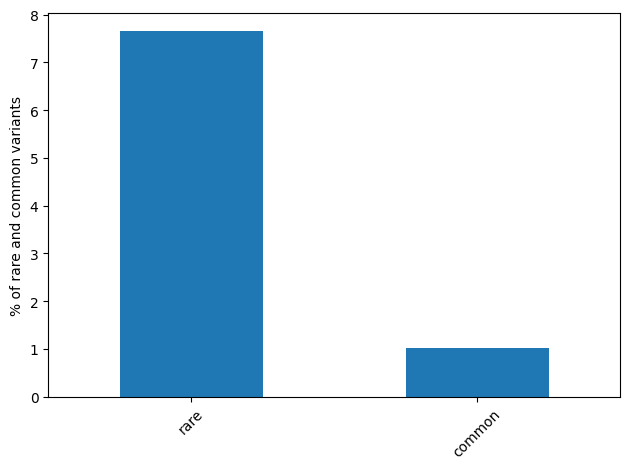

In [20]:
df_maf_var.plot.bar(x='anno', y='var%', legend=False, rot=45)
plt.xlabel('')
plt.ylabel('% of rare and common variants')
# plt.title('Variants per annotated region')
plt.tight_layout()
# plt.savefig(f'GVE_peak/figures/SNV_distribution_anno.pdf', bbox_inches='tight')
plt.show()

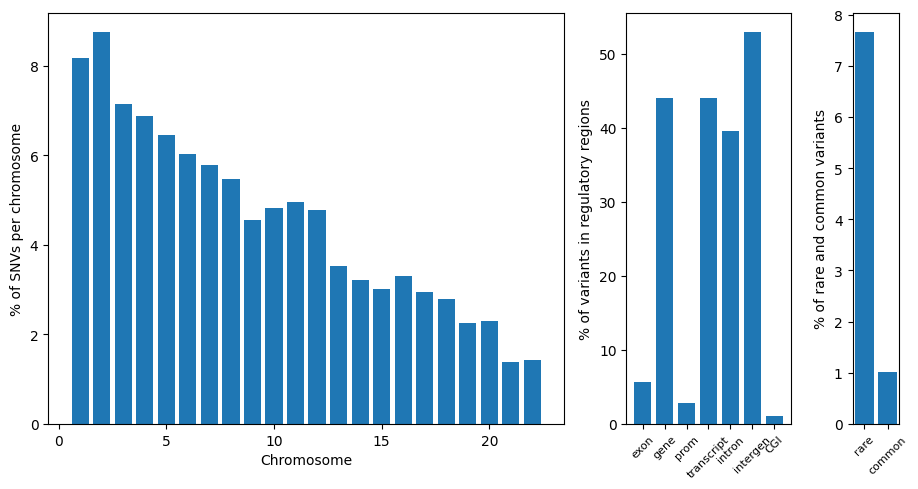

In [21]:
import matplotlib.pyplot as plt

# compute the width ratios
w1 = len(df_num_var)
w2 = len(df_anno_var)
w3 = len(df_maf_var)
widths = [w1, w2, w3]

# total figure width in inches (you can tweak the 0.3 factor)
fig_width = (w1 + w2 + w3) * 0.3
fig, axes = plt.subplots(
    1, 3,
    figsize=(fig_width, 5),
    gridspec_kw={'width_ratios': widths}
)

# 1) SNV distribution per chromosome
axes[0].bar(df_num_var['chrom'], df_num_var['var%'])
axes[0].set_xlabel('Chromosome')
axes[0].set_ylabel('% of SNVs per chromosome')

# 2) Variants in regulatory regions
axes[1].bar(df_anno_var['anno'], df_anno_var['var%'])
axes[1].set_xlabel('')
axes[1].set_ylabel('% of variants in regulatory regions')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)

# 3) Rare vs common variants
axes[2].bar(df_maf_var['anno'], df_maf_var['var%'])
axes[2].set_xlabel('')
axes[2].set_ylabel('% of rare and common variants')
axes[2].tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
# plt.savefig(f'GVE_peak/figures/SNV_distribution_anno.pdf', bbox_inches='tight')
plt.show()


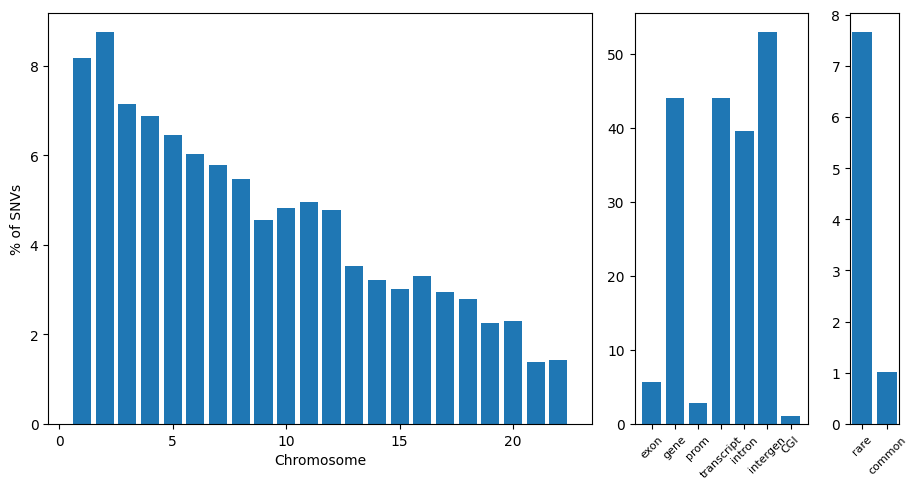

In [25]:
import matplotlib.pyplot as plt

# compute width ratios
w1 = len(df_num_var)
w2 = len(df_anno_var)
w3 = len(df_maf_var)
widths = [w1, w2, w3]

# scale factor for figure width per tick (tweak as needed)
scale = 0.3
fig_width = (w1 + w2 + w3) * scale

fig, axes = plt.subplots(
    1, 3,
    figsize=(fig_width, 5),
    sharey=False,
    gridspec_kw={'width_ratios': widths}
)

# 1) SNV distribution per chromosome
axes[0].bar(df_num_var['chrom'], df_num_var['var%'])
axes[0].set_xlabel('Chromosome')
axes[0].set_ylabel('% of SNVs')     # only on the leftmost plot

# 2) Variants in regulatory regions
axes[1].bar(df_anno_var['anno'], df_anno_var['var%'])
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)

# 3) Rare vs common variants
axes[2].bar(df_maf_var['anno'], df_maf_var['var%'])
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.savefig(f'GVE_peak/figures/SNV_distribution.pdf', bbox_inches='tight')
plt.show()


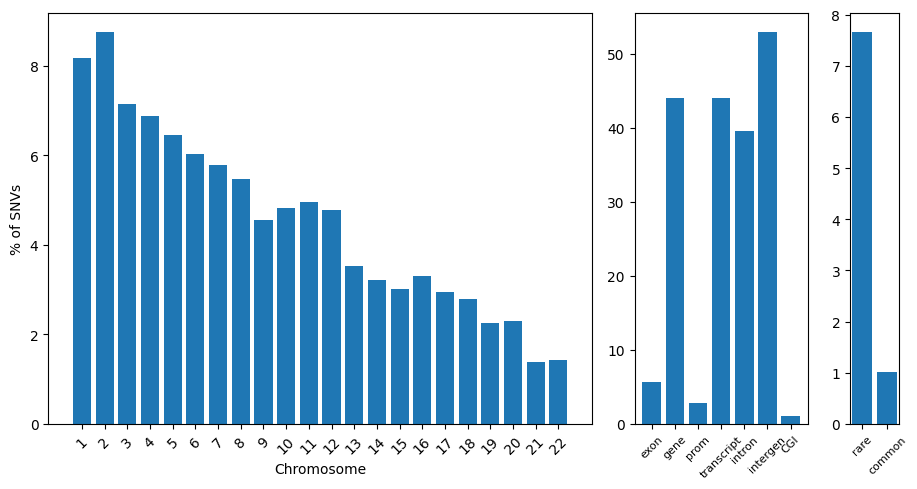

In [29]:
import matplotlib.pyplot as plt

# compute width ratios
w1 = len(df_num_var)
w2 = len(df_anno_var)
w3 = len(df_maf_var)
widths = [w1, w2, w3]

scale = 0.3
fig_width = (w1 + w2 + w3) * scale

fig, axes = plt.subplots(
    1, 3,
    figsize=(fig_width, 5),
    sharey=False,
    gridspec_kw={'width_ratios': widths}
)

# 1) SNV distribution per chromosome
axes[0].bar(df_num_var['chrom'], df_num_var['var%'])
axes[0].set_xlabel('Chromosome')
axes[0].set_ylabel('% of SNVs')

# force ticks 1–22
axes[0].set_xticks(list(range(1, 23)))
axes[0].set_xticklabels([str(i) for i in range(1, 23)], rotation=45)

# 2) Variants in regulatory regions
axes[1].bar(df_anno_var['anno'], df_anno_var['var%'])
axes[1].set_xlabel('')
axes[1].tick_params(axis='x', rotation=45, labelsize=8)

# 3) Rare vs common variants
axes[2].bar(df_maf_var['anno'], df_maf_var['var%'])
axes[2].set_xlabel('')
axes[2].tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.savefig(f'GVE_peak/figures/SNV_distribution.pdf', bbox_inches='tight')
plt.show()


In [43]:
gff_path = '/scratch/ml-csm/datasets/genomics/ref-genome/human/GRCh38/ensembl/variants/release-114/'
df_gff = pd.read_csv(gff_path + 'Homo_sapiens.GRCh38.114.gff3.gz', sep='\t', skiprows=203, header=None)
df_gff

,0,1,2,3,4,5,6,7,8
0,1,.,biological_region,10650.0,10657.0,0.999,+,.,logic_name=eponine
1,1,.,biological_region,10655.0,10657.0,0.999,-,.,logic_name=eponine
2,1,.,biological_region,10678.0,10687.0,0.999,+,.,logic_name=eponine
3,1,.,biological_region,10681.0,10688.0,0.999,-,.,logic_name=eponine
4,1,.,biological_region,10707.0,10716.0,0.999,+,.,logic_name=eponine
...,...,...,...,...,...,...,...,...,...
4186251,Y,.,biological_region,57215804.0,57215813.0,0.999,-,.,logic_name=eponine
4186252,Y,.,biological_region,57215832.0,57215840.0,0.999,+,.,logic_name=eponine
4186253,Y,.,biological_region,57215833.0,57215842.0,0.999,-,.,logic_name=eponine
4186254,Y,.,biological_region,57215862.0,57215867.0,0.999,+,.,logic_name=eponine


In [2]:
vcf_dir = '/scratch/ml-csm/projects/fgenom/gve/data/human/ensembl/GRCh38/variant/download/'
files = os.listdir(vcf_dir)
files.sort()
out_dir = '/scratch/ml-csm/projects/fgenom/gve/data/human/ensembl/GRCh38/variant/processed/'
files

['homo_sapiens-chr1.vcf.gz',
 'homo_sapiens-chr10.vcf.gz',
 'homo_sapiens-chr11.vcf.gz',
 'homo_sapiens-chr12.vcf.gz',
 'homo_sapiens-chr13.vcf.gz',
 'homo_sapiens-chr14.vcf.gz',
 'homo_sapiens-chr15.vcf.gz',
 'homo_sapiens-chr16.vcf.gz',
 'homo_sapiens-chr17.vcf.gz',
 'homo_sapiens-chr18.vcf.gz',
 'homo_sapiens-chr19.vcf.gz',
 'homo_sapiens-chr2.vcf.gz',
 'homo_sapiens-chr20.vcf.gz',
 'homo_sapiens-chr21.vcf.gz',
 'homo_sapiens-chr22.vcf.gz',
 'homo_sapiens-chr3.vcf.gz',
 'homo_sapiens-chr4.vcf.gz',
 'homo_sapiens-chr5.vcf.gz',
 'homo_sapiens-chr6.vcf.gz',
 'homo_sapiens-chr7.vcf.gz',
 'homo_sapiens-chr8.vcf.gz',
 'homo_sapiens-chr9.vcf.gz',
 'homo_sapiens-chrX.vcf.gz',
 'homo_sapiens-chrY.vcf.gz']

In [3]:
def file_path_gen(vcf_dir, out_dir):
    files = os.listdir(vcf_dir)
    for file in files:
        chr_vcf_file = os.path.join(vcf_dir, file)
        # print(chr_vcf_file)
        yield chr_vcf_file, out_dir


In [ ]:
def chr_vcf_process(dir_tuple):
    chr_vcf_file, out_dir = dir_tuple
    t1 = time.time()
    tail = os.path.split(chr_vcf_file)[1]
    out_file = tail[:-7]+'.tsv'
    out_file_path = os.path.join(out_dir, out_file)
    # print(f'processing data for: {tail}')
    VCF_REQUIRED_COLS = ["#CHROM", "POS", "ID", "REF", "ALT"]
    with gzip.open(chr_vcf_file, 'rb') as file_handle:
        lines = file_handle.readlines()
        index = 0
        for index, line in enumerate(lines):
            line = line.decode('utf8')
            # print(index, line)
            
            if '#' not in line:
                break
            if "#CHROM" in line:
                cols = line.strip().split('\t')
                if cols[:5] != VCF_REQUIRED_COLS:
                    raise ValueError(
                        "First 5 columns in file {0} were {1}. "
                        "Expected columns: {2}".format(
                            input_path, cols[:5], VCF_REQUIRED_COLS))
                index += 1
                break  
    # print(f'processing variants')           
    variants = []
    for line in lines[index:index+10]:
        line = line.decode('utf8')
        # print(line)
        cols = line.strip().split('\t')
        # print(cols[:5])
        variants.append(cols[:6])

    variants.insert(0, ["#CHROM", "POS", "ID", "REF", "ALT", "STRAND"])
    df_var = pd.DataFrame(variants)
    # print(f'Size of the data for {tail}: {df_var.shape[0]}')
    df_var.to_csv(out_file_path, sep='\t', header=None, index=False)
    t2 = time.time()
    print(f'Time take to process {tail} with size {df_var.shape[0]} is : {(t2-t1)/60} minutes')
    return out_file, df_var.shape[0]

In [17]:
# chr_vcf_process(chr_vcf_file, out_dir)

In [6]:
start = time.time()
pool = Pool(int(os.getenv('SLURM_CPUS_PER_TASK', len(files))))
dfs = pool.map(chr_vcf_process, file_path_gen(vcf_dir, out_dir))
dfs = list(dfs)
end = time.time()
print(f'Time taken: {(end-start)/60} minutes') 

Time take to process homo_sapiens-chrY.vcf.gz with size 1664979 is : 0.19414616028467815 minutes
Time take to process homo_sapiens-chr21.vcf.gz with size 9243119 is : 1.1693990389506022 minutes
Time take to process homo_sapiens-chr22.vcf.gz with size 9622810 is : 1.2289716521898906 minutes
Time take to process homo_sapiens-chr19.vcf.gz with size 15201975 is : 2.266575555006663 minutes
Time take to process homo_sapiens-chr20.vcf.gz with size 15418797 is : 2.324507733186086 minutes
Time take to process homo_sapiens-chr18.vcf.gz with size 18736707 is : 2.9250765840212503 minutes
Time take to process homo_sapiens-chr14.vcf.gz with size 21621403 is : 3.173971398671468 minutes
Time take to process homo_sapiens-chr17.vcf.gz with size 19772919 is : 3.2390400608380636 minutes
Time take to process homo_sapiens-chr15.vcf.gz with size 20235595 is : 3.2458054502805074 minutes
Time take to process homo_sapiens-chr16.vcf.gz with size 22226710 is : 3.747722597916921 minutes
Time take to process homo_s

In [9]:
n = 0
for item in dfs:
    
    n +=item[1]
    print(n)
print(n)

22226710
77177099
98798502
146896715
162315512
182088431
200825138
231373327
264628663
274251473
313172649
359393973
368637092
427439367
459888345
483553829
503789424
540607657
583946553
585611532
617758048
632960023
673529184
701366035
701366035


In [29]:
chr_vcf_folder = '/scratch/ml-csm/projects/fgenom/dna-met/mtl/gve/data/human/ensembl/GRCh38/variant/processed/chroms/'
chunk_out_dir = '/scratch/ml-csm/projects/fgenom/dna-met/mtl/gve/data/human/ensembl/GRCh38/variant/processed/chunks_500k/'
files = os.listdir(chr_vcf_folder)
files

['homo_sapiens-chr2.tsv',
 'homo_sapiens-chr6.tsv',
 'homo_sapiens-chr1.tsv',
 'homo_sapiens-chr4.tsv',
 'homo_sapiens-chr9.tsv',
 'homo_sapiens-chr5.tsv',
 'homo_sapiens-chr14.tsv',
 'homo_sapiens-chr10.tsv',
 'homo_sapiens-chr21.tsv',
 'homo_sapiens-chr12.tsv',
 'homo_sapiens-chr19.tsv',
 'homo_sapiens-chr11.tsv',
 'homo_sapiens-chr3.tsv',
 'homo_sapiens-chr22.tsv',
 'homo_sapiens-chr18.tsv',
 'homo_sapiens-chr20.tsv',
 'homo_sapiens-chr7.tsv',
 'homo_sapiens-chrY.tsv',
 'homo_sapiens-chr16.tsv',
 'homo_sapiens-chrX.tsv',
 'homo_sapiens-chr13.tsv',
 'homo_sapiens-chr15.tsv',
 'homo_sapiens-chr17.tsv',
 'homo_sapiens-chr8.tsv']

In [31]:
len(os.listdir(chunk_out_dir))

1391

In [ ]:
step = 500000 # size of the chunk to be saved
for file in files:
    data = pd.read_csv(chr_vcf_folder+file, sep='\t')
    print(file, data.shape)
    i = 0
    while i+step < data.shape[0]:
        df = data.iloc[i:i+step, :]
        file_name = file[:-4]+'_'+str(i)+'-'+str(i+step)+'.tsv'
        # df.to_csv(chunk_out_dir+file_name, sep='\t', header=None, index=False)
        i+=step
        
        if (i < data.shape[0]) & (i+step > data.shape[0]):
            df2 = data.iloc[i:data.shape[0], :]
            df = pd.concat([df, df2])
            print(df)
            file_name = file[:-4]+'_'+str(i-step)+'-'+str(data.shape[0])+'.tsv'
                           
        df.to_csv(chunk_out_dir+file_name, sep='\t', header=None, index=False)
            
    
print('Done !')

In [59]:
inPath = '/scratch/ml-csm/projects/fgenom/gve/data/human/ensembl/GRCh38/variant/processed/chroms/'
chroms = [i for i in range(1, 23)]
df = pd.DataFrame()
for chrom in chroms:
    chrom_file_path = inPath+'homo_sapiens-chr'+str(chrom)+'.tsv'
    data = pd.read_csv(chrom_file_path, sep='\t', usecols=[0, 1])
    data.columns = ['chrom', 'start']
    data.insert(loc=2, column='end', value = data['start']+1)
    df = pd.concat([df, data], axis=0)
    print(chrom, data.shape)

df.sort_values(by=['chrom', 'start'], inplace=True)

out_path = '~/Desktop/DNA_Methylation_Scripts/cpg_util_scripts/data/kmeans/annotations/enhancers/processed/'
df.to_csv(out_path+'ref_gen_var.bed', sep='\t', index=False, header=None)

1 (54950388, 3)
2 (58802274, 3)
3 (48098212, 3)
4 (46221323, 3)
5 (43338895, 3)
6 (40569160, 3)
7 (38921175, 3)
8 (36818232, 3)
9 (30548188, 3)
10 (32448977, 3)
11 (33255335, 3)
12 (32146515, 3)
13 (23665483, 3)
14 (21621402, 3)
15 (20235594, 3)
16 (22226709, 3)
17 (19772918, 3)
18 (18736706, 3)
19 (15201974, 3)
20 (15418796, 3)
21 (9243118, 3)
22 (9622809, 3)


(671864183, 3)

In [51]:
df = pd.DataFrame()
for file in files[9:16]:
    data = pd.read_csv(inPath+file, sep='\t', usecols=[0, 1])
    data.columns = ['chrom', 'start']
    data.insert(loc=2, column='end', value = data['start']+1)
    df = pd.concat([df, data], axis=0)
    print(file, data.shape)

df.sort_values(by=['chrom', 'start'], inplace=True)
out_path = '~/Desktop/DNA_Methylation_Scripts/cpg_util_scripts/data/kmeans/annotations/enhancers/processed/'
df.to_csv(out_path+'few_ref_chrom_var.bed', sep='\t', index=False, header=None)

homo_sapiens-chr19.tsv (15201974, 3)
homo_sapiens-chr11.tsv (33255335, 3)
homo_sapiens-chr3.tsv (48098212, 3)
homo_sapiens-chr22.tsv (9622809, 3)
homo_sapiens-chr18.tsv (18736706, 3)


,chrom,start,end
0,19,60062,60063
1,19,60165,60166
2,19,60173,60174
3,19,60184,60185
4,19,60223,60224
...,...,...,...
18736701,18,80263277,80263278
18736702,18,80263277,80263278
18736703,18,80263278,80263279
18736704,18,80263278,80263279


In [ ]:
inPath = '/scratch/ml-csm/projects/fgenom/dna-met/mtl/gve/data/refCpgHumGRCh38.csv'

outPath = '/scratch/ml-csm/projects/fgenom/dna-met/mtl/gve/data/chrom_cpg/'

data = pd.read_csv(inPath)
data['values'] = [0 for i in range(data.shape[0])]

df = data.loc[:, ['chrom', 'start', 'values']]

chroms = df.chrom.unique()
for chrom in chroms:    
    df_chr = df[df.chrom==chrom]
    df_chr.to_csv(outPath+chrom+'.tsv', sep='\t', header=None, index=False)
    print(chrom)
    
print('Done !')